## Predict 1 week at a time for dates before 2016
1. Train model for 2 years
2. Predict 1 week via IncrementalModel
3. Repeat starting with next week

In [1]:
from BorderModel import run_Incremental, harmonic_mean
from BorderQuery import insert_predictions
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
import datetime
import random
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import copy
import pdb
from sklearn.metrics import r2_score
import cPickle as pickle

In [2]:
def create_train_test(date_end, test_days=7, train_years=2):
    '''
    IN 
        date_end: datetime.date of last day to predict
        duration: days to predict
        train_years: number of years to train
    '''
    train_start = date_end - datetime.timedelta(test_days + 366 * train_years)
    train_end = date_end - datetime.timedelta(test_days)
    test_start = date_end - datetime.timedelta(test_days)
    test_end = date_end
    return train_start, train_end, test_start, test_end
    
def run_multiweek(model, munger_id, crossing_id, first, last, test_days):
    prlist = {}
    test_date = first
    while test_date < last:
        cpu = random.randint(0, 31)
        train_start, train_end, test_start, test_end = create_train_test(test_date, test_days=test_days)

        prlist[str(test_date)] = rc[cpu].apply_async(run_Incremental, model, munger_id, crossing_id,  
                                           train_start, train_end, 
                                           test_start, test_end)
        
        test_date += datetime.timedelta(test_days)
        
    return prlist

def score_df(models):
    predict = {date: model.score()['model'] for date, model in models.items()}
    ensemble = {date: model.score()['ensemble'] for date, model in models.items()}
    baseline = {date: model.score()['baseline'] for date, model in models.items()}
    
    df = pd.DataFrame([predict, ensemble, baseline]).T
    df.columns = ['predict', 'ensemble', 'baseline']
    df.index.name = 'date'
    df.index = pd.to_datetime(df.index)
    return df

def plot_scores(df):
    plt.figure(figsize=(16,4))
    plt.plot(df.baseline, label='baseline')
    plt.plot(df.predict, label='predict')
    plt.plot(df.ensemble, label='ensemble')
    plt.axhline(0, color='y')
    plt.legend();
    
def results_df(trained_models):
    predict = pd.Series().append([model.y_predict for key, model in trained_models.items()]).sort_index()
    ensemble = pd.Series().append([model.ensemble() for key, model in trained_models.items()]).sort_index()
    baseline = pd.Series().append([model.baseline() for key, model in trained_models.items()]).sort_index()
    actual = pd.Series().append([model.actual for key, model in trained_models.items()]).sort_index()
  
    df = pd.DataFrame()
    df['predict'] = predict
    df['ensemble'] = ensemble
    df['baseline'] = baseline
    df['actual'] = actual
    return df

def print_r2(results):
    actual = results.actual.dropna()
    print 'Predict: ', r2_score(actual, results.predict[actual.index])
    print 'Ensemble: ', r2_score(actual, results.ensemble[actual.index])
    print 'Baseline: ', r2_score(actual, results.baseline[actual.index])
    
# def get_trained(pr, first, last, test_days, exclude):
def get_trained(pr, exclude):
    trained = {}
    test_date = first
    for date in sorted(pr.keys()):
        if date not in [str(ex) for ex in exclude]:
            if pr[date].ready():
                trained[date] = pr[date].get(1)
                print date, trained[date].score()
            else:
                print date, 'not ready'
            
    return trained

In [3]:
import os
from ipyparallel import Client
rc = Client()
dview = rc[:]

# set proper working directory on all clients
cwd = os.getcwd()
dview.map(os.chdir, [cwd] * 40)
# print(dview.apply_sync(os.getcwd))

with dview.sync_imports():
    import datetime
    from BorderModel import run_Incremental
    from BorderQuery import select_features, select_mungedata_simple, select_mungedata
    from sklearn.ensemble import ExtraTreesRegressor
    from sklearn.grid_search import GridSearchCV

importing datetime on engine(s)
importing run_Incremental from BorderModel on engine(s)
importing select_features,select_mungedata_simple,select_mungedata from BorderQuery on engine(s)
importing ExtraTreesRegressor from sklearn.ensemble on engine(s)
importing GridSearchCV from sklearn.grid_search on engine(s)


## Peace Arch South

### 2015

In [8]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

pr = run_multiweek(grid, 3, 1, datetime.date(2015, 1, 1), datetime.date(2016, 1, 1), 7)

In [16]:
trained = {}
first = datetime.date(2015, 1, 1)
last = datetime.date(2016, 1, 1)
test_days = 7
test_date = first
exclude = [datetime.date(2015, 2, 19)]
while test_date < last:
    if test_date not in exclude:
        if pr[str(test_date)].ready():
            trained[str(test_date)] = pr[str(test_date)].get(1)
            print test_date, trained[str(test_date)].score()
        else:
            print  test_date, pr[str(test_date)].ready()

    test_date += datetime.timedelta(test_days)

2015-01-01 {'model': 0.58128200781843775, 'ensemble': 0.52990815747682307, 'baseline': 0.4953655728098576}
2015-01-08 {'model': 0.12400183899221018, 'ensemble': 0.28527994328097739, 'baseline': 0.3482164076815002}
2015-01-15 {'model': -3.1312980884100128, 'ensemble': -3.4745395708412437, 'baseline': -4.3948089687924909}
2015-01-22 {'model': -0.97769819000414815, 'ensemble': -1.1557025950100703, 'baseline': -1.7942496352676716}
2015-01-29 {'model': -0.46928274087763766, 'ensemble': -0.70397654751423411, 'baseline': -1.5500452984629245}
2015-02-05 {'model': -0.0026863062294202322, 'ensemble': -0.44406904911785161, 'baseline': -2.7982134283227738}
2015-02-12 {'model': 0.66970148363298332, 'ensemble': 0.71106175413340778, 'baseline': 0.52540316434315615}
2015-02-26 {'model': 0.51553721733538704, 'ensemble': 0.56237136261589149, 'baseline': 0.47332788089234268}
2015-03-05 {'model': 0.42326254157553433, 'ensemble': 0.21481358097889702, 'baseline': -0.49784403039616953}
2015-03-12 {'model': 0

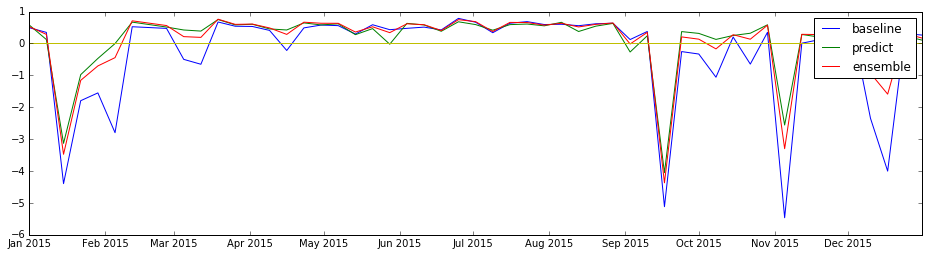

In [18]:
scores = score_df(trained)
plot_scores(scores)

In [24]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_1_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])

Predict:  0.437260053124
Ensemble:  0.453806375313
Baseline:  0.356917688188


### Note that baseline is a rolling 12 months, so not unexpected that baseline improves with week by week approach

In [70]:
full2015 = run_Incremental(grid, 3, 1, '2013-1-1', '2015-1-1', '2015-1-1', '2016-1-1')

In [71]:
full2015.score()

{'baseline': 0.1059067680212642,
 'ensemble': 0.18871318906645274,
 'model': 0.11903765655965948}

### 2014

In [94]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2014, 1, 1)
last = datetime.date(2015, 1, 1)
pr1 = run_multiweek(grid, 3, 1, first, last, 7)

In [114]:
exclude = [str(datetime.date(2014,11,19))]
trained = get_trained(pr1, exclude)

2014-01-01 {'model': 0.56487999142901513, 'ensemble': 0.57717006242105118, 'baseline': 0.61146059743264947}
2014-01-08 {'model': 0.4941868429198677, 'ensemble': 0.54534829749203995, 'baseline': 0.51422868976803038}
2014-01-15 {'model': -1.9214456283204027, 'ensemble': -2.684659857654411, 'baseline': -4.2707328678725531}
2014-01-22 {'model': 0.55996118282139529, 'ensemble': 0.62754390882608324, 'baseline': 0.44449685512174641}
2014-01-29 {'model': 0.50652355153841411, 'ensemble': 0.37911684969755444, 'baseline': -0.087001447126558551}
2014-02-05 {'model': 0.8000777369440929, 'ensemble': 0.75591116339996045, 'baseline': 0.51890564962789432}
2014-02-12 {'model': 0.68005045446447321, 'ensemble': 0.74560706036418489, 'baseline': 0.78655945008022798}
2014-02-19 {'model': 0.64353190801326832, 'ensemble': 0.61419981193552253, 'baseline': 0.5867179126823614}
2014-02-26 {'model': 0.54223695549882422, 'ensemble': 0.46638464144059022, 'baseline': 0.29547402196659822}
2014-03-05 {'model': 0.7923664

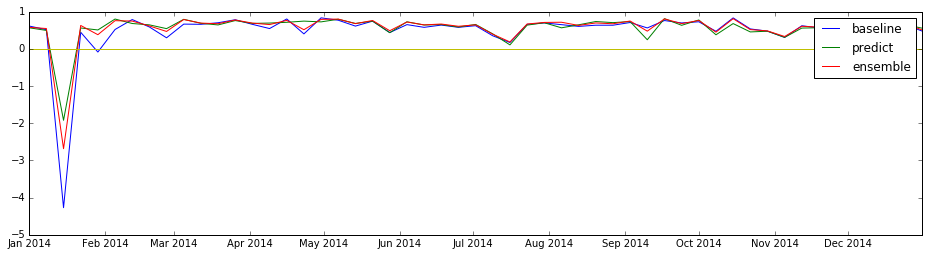

In [115]:
scores = score_df(trained)
plot_scores(scores)

In [116]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_1_2014.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2014-1-1':'2015-1-1'])

Predict:  0.628178570346
Ensemble:  0.634929628165
Baseline:  0.595947033601


## Pacific Highway South

### 2015

In [26]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

pr = run_multiweek(grid, 3, 5, datetime.date(2015, 1, 1), datetime.date(2016, 1, 1), 7)

In [37]:
first = datetime.date(2015, 1, 1)
last = datetime.date(2016, 1, 1)
test_days = 7
exclude = [datetime.date(2015, 10, 15), datetime.date(2015, 2, 19)]

trained = get_trained(first, last, test_days, exclude)

2015-01-01 {'model': 0.46990307719014135, 'ensemble': 0.50284696366738424, 'baseline': 0.53360635276911372}
2015-01-08 {'model': 0.38909399024410873, 'ensemble': 0.43317233422625923, 'baseline': 0.42777892104205117}
2015-01-15 {'model': -2.0167523567331953, 'ensemble': -2.1575372502433772, 'baseline': -2.5594198289083412}
2015-01-22 {'model': 0.25022423977961805, 'ensemble': -0.024464794150649505, 'baseline': -0.71456686843956074}
2015-01-29 {'model': -0.24304107629025085, 'ensemble': -0.62468547750129755, 'baseline': -1.8131967463785328}
2015-02-05 {'model': 0.53581912193230563, 'ensemble': 0.35643380354943732, 'baseline': -1.2446526859107325}
2015-02-12 {'model': 0.58348068019601507, 'ensemble': 0.67736120724406579, 'baseline': 0.56255811702560932}
2015-02-26 {'model': 0.54658268613935368, 'ensemble': 0.63090487795934824, 'baseline': 0.37507249104058504}
2015-03-05 {'model': 0.53094204792758137, 'ensemble': 0.40041087755609972, 'baseline': -0.49281888391150352}
2015-03-12 {'model': 0

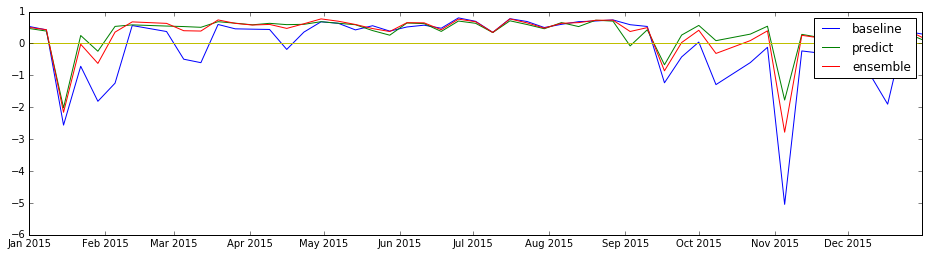

In [38]:
scores = score_df(trained)
plot_scores(scores)

In [39]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])

Predict:  0.510585079272
Ensemble:  0.522367396674
Baseline:  0.419433496676


### 2014

In [96]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2014, 1, 1)
last = datetime.date(2015, 1, 1)
pr5 = run_multiweek(grid, 3, 5, first, last, 7)

In [110]:
exclude = [datetime.date(2014,11,19)]
trained = get_trained(pr5, exclude)

2014-01-01 {'model': 0.53622152908081733, 'ensemble': 0.56914992923004504, 'baseline': 0.59970573476520472}
2014-01-08 {'model': 0.5252129063634503, 'ensemble': 0.59439868576776433, 'baseline': 0.54023361209490761}
2014-01-15 {'model': -0.19621410701440234, 'ensemble': -0.83868287364778893, 'baseline': -2.5927010555044534}
2014-01-22 {'model': 0.66151919252941971, 'ensemble': 0.66903346435836342, 'baseline': 0.37152985946751438}
2014-01-29 {'model': 0.48148253292636045, 'ensemble': 0.21503410609888352, 'baseline': -0.7456312876385629}
2014-02-05 {'model': 0.74799843201262883, 'ensemble': 0.65475145287831271, 'baseline': 0.073126954210557593}
2014-02-12 {'model': 0.74726114641428265, 'ensemble': 0.79454247457153448, 'baseline': 0.72409978111470263}
2014-02-19 {'model': 0.69845069994451225, 'ensemble': 0.68079800088843045, 'baseline': 0.54912057791775026}
2014-02-26 {'model': 0.54751984527975139, 'ensemble': 0.49502967020315092, 'baseline': 0.24242911295897718}
2014-03-05 {'model': 0.756

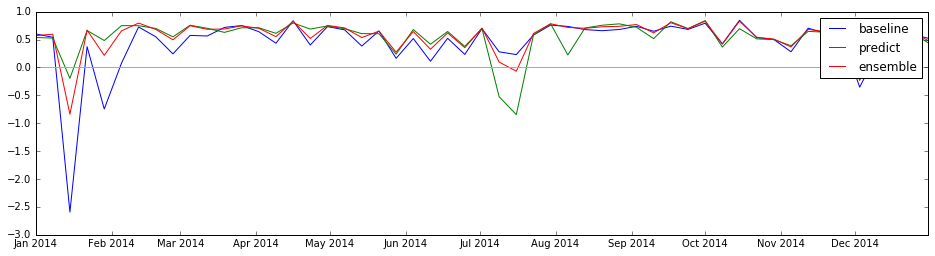

In [111]:
scores = score_df(trained)
plot_scores(scores)

In [112]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2014.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2014-1-1':'2015-1-1'])

Predict:  0.609117332063
Ensemble:  0.635295178947
Baseline:  0.571960977333


## Peace Arch North
### 2015

In [5]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2015, 1, 1)
last = datetime.date(2016, 1, 1)
pr2 = run_multiweek(grid, 4, 2, first, last, 7)

In [6]:
exclude = []#[datetime.date(2014,11,19)]
trained = get_trained(pr2, exclude)

2015-01-01 not ready
2015-01-08 not ready
2015-01-15 not ready
2015-01-22 not ready
2015-01-29 not ready
2015-02-05 not ready
2015-02-12 not ready
2015-02-19 not ready
2015-02-26 not ready
2015-03-05 not ready
2015-03-12 not ready
2015-03-19 not ready
2015-03-26 not ready
2015-04-02 not ready
2015-04-09 not ready
2015-04-16 not ready
2015-04-23 not ready
2015-04-30 not ready
2015-05-07 not ready
2015-05-14 not ready
2015-05-21 not ready
2015-05-28 not ready
2015-06-04 not ready
2015-06-11 not ready
2015-06-18 not ready
2015-06-25 not ready
2015-07-02 not ready
2015-07-09 not ready
2015-07-16 not ready
2015-07-23 not ready
2015-07-30 not ready
2015-08-06 not ready
2015-08-13 not ready
2015-08-20 not ready
2015-08-27 not ready
2015-09-03 not ready
2015-09-10 not ready
2015-09-17 not ready
2015-09-24 not ready
2015-10-01 not ready
2015-10-08 not ready
2015-10-15 not ready
2015-10-22 not ready
2015-10-29 not ready
2015-11-05 not ready
2015-11-12 not ready
2015-11-19 not ready
2015-11-26 no

In [ ]:
scores = score_df(trained)
plot_scores(scores)

In [ ]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_2_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])

## Pacific Highway North
### 2015

In [4]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2015, 1, 1)
last = datetime.date(2016, 1, 1)
pr6 = run_multiweek(grid, 4, 6, first, last, 7)

In [127]:
exclude = []#[datetime.date(2014,11,19)]
trained = get_trained(pr6, exclude)

2015-01-01 not ready
2015-01-08 not ready
2015-01-15 not ready
2015-01-22 not ready
2015-01-29 not ready
2015-02-05 not ready
2015-02-12 not ready
2015-02-19 not ready
2015-02-26 not ready
2015-03-05 not ready
2015-03-12 not ready
2015-03-19 not ready
2015-03-26 not ready
2015-04-02 not ready
2015-04-09 not ready
2015-04-16 not ready
2015-04-23 not ready
2015-04-30 not ready
2015-05-07 not ready
2015-05-14 not ready
2015-05-21 not ready
2015-05-28 not ready
2015-06-04 not ready
2015-06-11 not ready
2015-06-18 not ready
2015-06-25 not ready
2015-07-02 not ready
2015-07-09 not ready
2015-07-16 not ready
2015-07-23 not ready
2015-07-30 not ready
2015-08-06 not ready
2015-08-13 not ready
2015-08-20 not ready
2015-08-27 not ready
2015-09-03 not ready
2015-09-10 not ready
2015-09-17 not ready
2015-09-24 not ready
2015-10-01 not ready
2015-10-08 not ready
2015-10-15 not ready
2015-10-22 not ready
2015-10-29 not ready
2015-11-05 not ready
2015-11-12 not ready
2015-11-19 not ready
2015-11-26 no

In [ ]:
scores = score_df(trained)
plot_scores(scores)

In [ ]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_2_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])